In [1]:
import sys
sys.path.append('/home/jhernandez/Work//')
sys.path.append('/home/jhernandez/Work/python_tools/')

from defaults import *

import scipy.interpolate as interp
import skill_metrics as sm
import time

## Analyze Velocities in OSSE 



##### **Define experiment period**

In [18]:
# Define initial and end date
date_ini = datetime(2014,9,21)
date_end = datetime(2014,10,19)

ndays = (date_end - date_ini).days
dates = [date_ini + timedelta(days=d +1) for d in range(ndays)]

# Experiment names from which to extract equivalents to observations and to calculate RMSD
experiments = ['NR', 'NOASSIM', 'generic_nudging', 'totals_actual_nudging', 'totals_future_nudging']
exp_period = 'Oct2014'

In [14]:
# Define initial and end date
date_ini = datetime(2014,8,1)
date_end = datetime(2014,8,27)

ndays = (date_end - date_ini).days
dates = [date_ini + timedelta(days=d +1) for d in range(ndays)]

# Experiment names from which to extract equivalents to observations and to calculate RMSD
experiments = ['NR', 'NOASSIM', 'generic_nudging', 'totals_actual_nudging', 'totals_future_nudging']
exp_period = 'Aug2014'

In [15]:
#areas = {'small': [0.72, 1.2, 38.6, 38.85],
 #        'medium': [0.2, 1.2,  38.6, 39.0],
  #       'medium2': [0.2, 1.35,  38.4, 39.0],
   #      'big': [0.1, 1.35,  38.3, 39.2]
    #    }

areas = {'big': [-0.2, 1.6,  38.0, 39.5]
        }


#### **Plot Areas**

**Load Polygons of Present and Future HFR coverage areas**

In [16]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

coverage_name = ['actual', 'future']
lonc = {}
latc = {}

for cov in coverage_name:
    # Path  to Nature Run
    nr_path = "/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_GLORYS_v1_3hourly/"

    # Path to shapefile
    shape_path = '/home/jhernandez/Escritorio/hfr_coverage_geodata/'
    shape_file = glob(shape_path + '/*' + cov + '*shp')
    # Load Shapefile
    shape = shapefile.Reader(shape_file[0])

    feature = shape.shapeRecords()[0]
    first = feature.shape.__geo_interface__ 
    coverage = Polygon(feature.shape.points)
    
    lonc[cov] = [c[0] for c in first['coordinates'][0]]
    latc[cov] = [c[1] for c in first['coordinates'][0]]

#### **Get metrics for velocities in the different areas around te Ibiza Channel**

In [20]:
start_time = time.time()

df = {}
df['u'] = {}
df['v'] = {}

area = 'big'
    
u = {}
v = {}
u_total = {}  # array containing all wmop obs
v_total = {}  # array containing all wmop obs

print(F"---- Computing HFR DA metrics for {area} Ibiza Channel area ------")
limits = areas[area]

for exp in experiments: 

    if (exp == 'NOASSIM') & (exp_period == 'Oct2014'):
        path_wmop = F"/home/modelling/data/workdir_2/Data_assimilation_experiments/HFR_DA_oct2014//HFR_{exp}_Oct2014"
        files_wmop = [F"{path_wmop}/roms_WMOP_ASSIM_{d.strftime('%Y%m%d')}_avg.nc" for d in dates]


    elif (exp == 'NOASSIM') & (exp_period == 'Aug2014'):
        path_wmop = F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17_3hourly/"
        files_wmop = [F"{path_wmop}/{d.strftime('%Y/%m/%d/')}/roms_WMOP_HINDCAST_{d.strftime('%Y%m%d')}_avg.nc" for d in dates]

    elif (exp == 'NR'):
        path_wmop = F"/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_GLORYS_v1_3hourly"
        files_wmop = [F"{path_wmop}/{d.strftime('%Y/%m/%d/')}/roms_WMOP_HINDCAST_{d.strftime('%Y%m%d')}_avg.nc" for d in dates]

    else:
        path_wmop = F"/mnt/vinson/DATA/jhernandez/ROMS/Outputs//HFR_{exp}_{exp_period}_OSSE_Glorys_3h/"
        files_wmop = [F"{path_wmop}/roms_WMOP_ASSIM_{d.strftime('%Y%m%d')}_avg.nc" for d in dates]

    ds_wmop = xr.open_mfdataset(files_wmop)

    du = ds_wmop['u'].where((ds_wmop.lon_u>limits[0]) & (ds_wmop.lon_u<limits[1]) & (ds_wmop.lat_u>limits[2]) & (ds_wmop.lat_u<limits[3]), drop=True)
    dv = ds_wmop['v'].where((ds_wmop.lon_v>limits[0]) & (ds_wmop.lon_v<limits[1]) & (ds_wmop.lat_v>limits[2]) & (ds_wmop.lat_v<limits[3]), drop=True)

    u[exp] = du[:,-1,:,:].values
    v[exp] = dv[:,-1,:,:].values

    u_ = u[exp].flatten()
    u_total[exp] = u_[~np.isnan(u_)]        
    v_ = v[exp].flatten()
    v_total[exp] = v_[~np.isnan(v_)]

    print(F"Fields within the Radar domain extracted for {exp}")


variables = {'u': u_total, 'v': v_total}

for vn in variables:

    sdev = []; crmsd = []; ccoef = []; rmsd_mean = []; bias = []; taylor_stats = {}
    #df[v] = {}
    # Calculate taylor diagram stats for the different experiments selcted
    for e in experiments:
        taylor_stats[e] = sm.taylor_statistics(variables[vn][e], variables[vn]['NR'])
        sdev.append(taylor_stats[e]['sdev'][1])
        crmsd.append(taylor_stats[e]['crmsd'][1])
        ccoef.append(taylor_stats[e]['ccoef'][1])
        rmsd_mean.append( sm.rmsd(variables[vn][e], variables[vn]['NR']))
        bias.append( np.nanmean( variables[vn][e] - variables[vn]['NR']))

    data = {'rmsd': rmsd_mean, 'sdev': sdev, 'crmsd': crmsd, 'ccoef': ccoef, 'bias': bias}
    df[vn][area] = pd.DataFrame(data, index=['Obs', 'CR', 'GNR', 'TOT-Actual', 'TOT-Future'])


print("--- %s seconds ---" % (time.time() - start_time))

---- Computing HFR DA metrics for big Ibiza Channel area ------
Fields within the Radar domain extracted for NR
Fields within the Radar domain extracted for NOASSIM
Fields within the Radar domain extracted for generic_nudging
Fields within the Radar domain extracted for totals_actual_nudging
Fields within the Radar domain extracted for totals_future_nudging
--- 218.07923364639282 seconds ---


## Plot Surface Currents Fields

In [21]:
from tools import set_font_size

In [22]:
xloc = [0.10, 0.5, 0.9, 1.3]

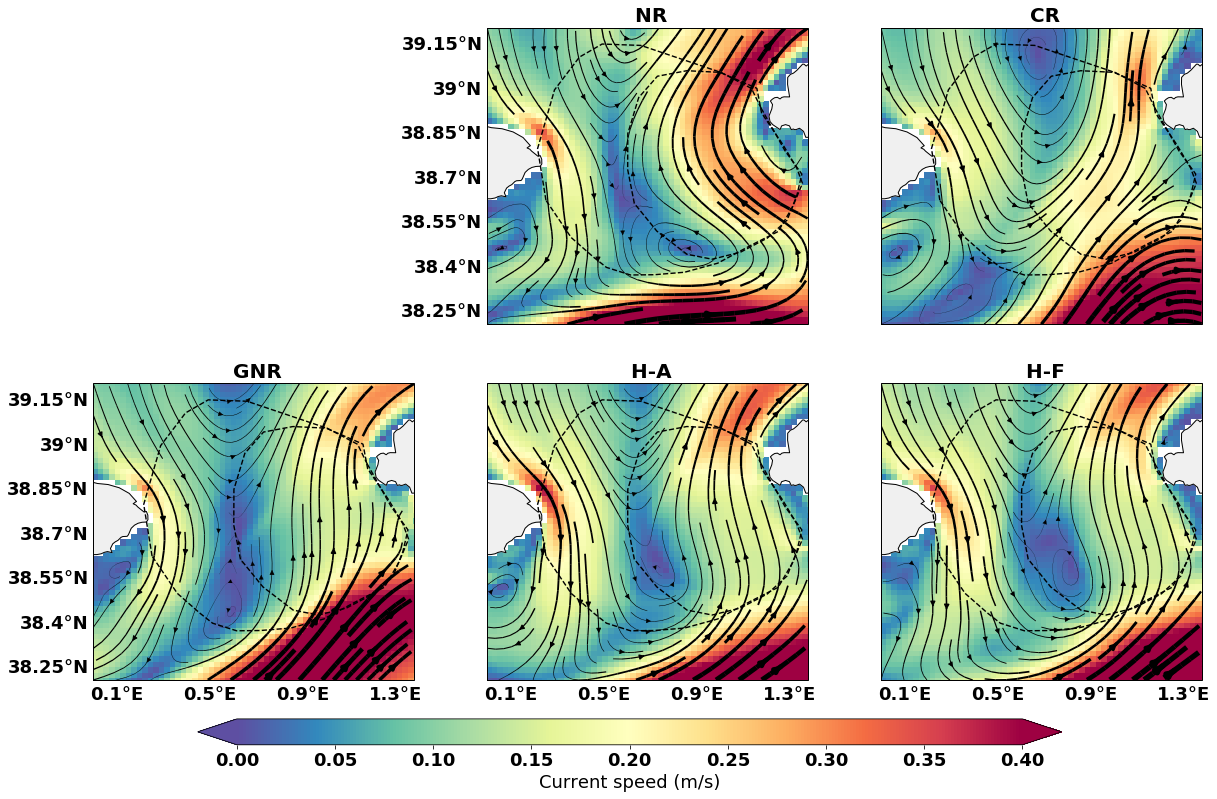

In [28]:
import cartopy.feature as cfeature

simulation_list = {'NR': 'NR',
                   'NOASSIM': 'CR',
                   'generic_nudging': 'GNR',
                   'totals_actual_nudging': 'H-A',
                   'totals_future_nudging': 'H-F'
                  }

set_font_size(18)

lon0 = du.lon_u.values[:,:-1]
lat0 = du.lat_u.values[:,:-1]

fig = plt.figure(figsize=(20,12))

for i, simulation_name in enumerate(simulation_list):
    
    u_mean = np.nanmean(u[simulation_name], axis=0)[:,:-1]
    uq = u_mean[::sset, ::sset]
    v_mean = np.nanmean(v[simulation_name], axis=0)
    vq = v_mean[::sset, ::sset]

    speed = np.sqrt(u_mean**2 + v_mean**2)

    ax, gl = tools.make_map(continents=True, limits=[0, 1.38, 38.2, 39.2], subplot_dim=(2,3,i+2), xloc = xloc, fsize=18)
    a = plt.pcolormesh(lon0, lat0, speed, transform=gl.crs, cmap='Spectral_r', vmin=0, vmax=0.4)
    
    #ax.add_feature(cfeature.GSHHSFeature(scale='h',facecolor=[0.3,0.2,0.2]))
    if i in [1,3,4,5]:
        gl.ylabels_left = False
    if i in [0,1]:
        gl.xlabels_bottom = False

    plt.plot(lonc['actual'], latc['actual'], 'k--', transform=gl.crs, linewidth=1.4)
    plt.plot(lonc['future'], latc['future'], 'k--', transform=gl.crs, linewidth=1.4)

    #q = ax.quiver(lon, lat, uq, vq, transform=gl.crs, scale=4, animated=True, headlength=15, headwidth=6, pivot='middle')
    #ax.quiverkey(q, 0.1, 0.8,0.5,'0.5 m/s')
    plt.streamplot( lon0, lat0, u_mean, v_mean, transform=gl.crs, linewidth=speed*10, color='black')

    plt.title(F' {simulation_list[simulation_name]}', fontsize=20, fontweight='bold')
    

cbar_ax = fig.add_axes([0.20, 0.05, 0.60, 0.03])
fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')
cbar_ax.set_xlabel('Current speed (m/s)')

plt.show()

In [29]:
plot_path = "/home/jhernandez/Escritorio//"
fig.savefig(F"{plot_path}/current_speed_5-simulations_{exp_period}_OSSE_v2.png", dpi=250, transparent=False, facecolor="w")